In [56]:
import numpy as np
from scipy.optimize import linprog
import networkx as nx
import matplotlib
%matplotlib inline

In [2]:
def draw_graph(G):
    nx_G = nx.from_dict_of_lists(G)
    nx.draw_networkx(nx_G)

# Linear Program for fractional clique number

Define a function to return all possible subsests for list of vertices V

In [3]:
def subsets(V, prefix=[], arr_sets=[]):
    if V == []: return
    for i in range(len(V)):
        subset = prefix + [V[i]]
        arr_sets += [subset]
        subsets(V[i+1:], subset, arr_sets)

In [4]:
def check_clique(graph, v_set):
    if len(v_set) < 2: return True
    for i in range(len(v_set)):
        i_set = set(v_set[:i] + v_set[i+1:])
        g_set = graph[v_set[i]]
        if i_set & g_set != i_set :
            return False
    return True

In [5]:
def A_clique_set(graph, v_encode, subsets, A=[]):
    for subset in subsets:
        if check_clique(graph, subset):
            A += [sum([v_encode[v] for v in subset])]

In [6]:
def lp_clique(graph):
    V = list(graph.keys())
    v_encode = {}
    v_num = len(V)
    
    for i in range(v_num):
        temp = np.zeros(v_num)
        temp[i] = -1
        v_encode[V[i]] = temp
    
    arr_sets = []
    subsets(V, arr_sets=arr_sets)
    
    b_clique = np.negative(np.ones(v_num))
    A_clique = []
    A_clique_set(graph, v_encode, arr_sets,A=A_clique)
    A_clique = np.transpose(np.array(A_clique))
    c_clique = np.ones(A_clique.shape[1])
    
    res = linprog(c_clique, A_ub=A_clique, b_ub=b_clique, bounds=(0, None))
    return res, A_clique

# Linear Program for Shannon entropy

In [7]:
def remove_unconnected_v(graph):
    keys = list(graph.keys())
    for v in keys:
        if len(graph[v]) == 0:
            graph.pop(v, None)

In [8]:
G10 = {1:set({}), 2:set({}), 3:set({}), 4:set({}), 5:set({}), 6:set({})}

In [9]:
remove_unconnected_v(G10)

In [10]:
G10

{}

In [11]:
def subsets_dict(V, prefix=[], arr_sets={}):
    if V == []: return 1
    for i in range(len(V)):
        subset = prefix + [V[i]]
        arr_sets[tuple(subset)] = len(arr_sets)
        subsets_dict(V[i+1:], subset, arr_sets)

In [12]:
def A_entropy_set(V, subsets_dict, A=[], b=[]):
    num_sets = len(subsets_dict)
    for subset in subsets_dict:
        subset_len = len(subset)
        subset_i = subsets_dict[subset]
        a_lq = np.zeros(num_sets)
        if subset_len > 1:
            a_lq[subset_i] = -1 * (subset_len)
            a_mq = np.zeros(num_sets)
            a_mq[subset_i] = subset_len - 1
            s = set(subset)
            for v in subset:
                sub_i = subsets_dict[tuple(x for x in subset if v != x)]
                a_lq[sub_i] = 1    
                a_mq[sub_i] = -1
            A += [a_lq, a_mq]
            b += [0, 0]
        else:
            a_lq[subset_i] = 1
            A += [a_lq]
            b += [1]

In [13]:
def A_entropy_set_2(V, subsets_dict, A=[], b=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = subsets_dict[subset_i]
        for j in range(i, num_sets):
            subset_j = subsets[j]
            pos_j = subsets_dict[subset_j]
            a_lq = np.zeros(num_sets)
            if len(subset_i) < 2 and pos_i == pos_j: 
                a_lq[pos_i] = 1
                A += [a_lq]
                b += [1]
#                 print("identical", subset_i)
            else:
                a_mq = np.zeros(num_sets)
                subset_i = set(subset_i)
                subset_j = set(subset_j)
                subset_ij_u = subset_i | subset_j
                subset_ij_i = subset_i & subset_j
                if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                    if len(subset_i) > len(subset_j):
                        a_mq[pos_i] = -1
                        a_mq[pos_j] = 1
                        A += [a_mq]
                        b += [0]
                    elif len(subset_i) < len(subset_j):
                        a_mq[pos_i] = 1
                        a_mq[pos_j] = -1
                        A += [a_mq]
                        b += [0]
#                     print("intersect each other", subset_i, subset_j)
                else:
#                     print("not intersection of each other", subset_i, subset_j)
                    a_lq[pos_i] = -1
                    a_lq[pos_j] = -1
                    a_lq[subsets_dict[tuple(subset_ij_u)]] = 1
                    if len(subset_ij_i) > 0:
                        a_lq[subsets_dict[tuple(subset_ij_i)]] = 1
                    A += [a_lq]
                    b += [0]

This version is missing a lot of important conditions

In [14]:
def A_entropy_set_3(V, subsets_dict, A=[], b=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = subsets_dict[subset_i]
        for j in range(i, num_sets):
            subset_j = subsets[j]
            pos_j = subsets_dict[subset_j]
            a_mq = np.zeros(num_sets)
            if len(subset_i) < 2 and pos_i == pos_j: 
                a_mq[pos_i] = 1
                A += [a_mq]
                b += [1]
            else:
                subset_i = set(subset_i)
                subset_j = set(subset_j)
                subset_ij_u = subset_i | subset_j
                subset_ij_i = subset_i & subset_j
                if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                    if len(subset_i) > len(subset_j):
                        a_mq[pos_i] = -1
                        a_mq[pos_j] = 1
                        A += [a_mq]
                        b += [0]
                    elif len(subset_i) < len(subset_j):
                        a_mq[pos_i] = 1
                        a_mq[pos_j] = -1
                        A += [a_mq]
                        b += [0]
        
        if len(subset_i) > 1:
            a_lq = np.zeros(num_sets)
            a_lq[pos_i] = 1
            for v in subset_i:
                sub_i = subsets_dict[(v,)]
                a_lq[sub_i] = -1
            A += [a_lq]
            b += [0]


In [15]:
def entropy_eq_dict(graph, eq_dict={}):
    for v in graph:
        n = tuple(graph[v])
        n_v = tuple(graph[v] | {v})
        if n in eq_dict:
            eq_dict[n_v] = eq_dict[n]
        else:
            eq_dict[n] = n_v    

In [46]:
def A_entropy_set_4(graph, subsets_dict, eq_dict,  A=[]):
    num_sets = len(subsets_dict)
    subsets = list(subsets_dict.keys())
    for i in range(num_sets):
        subset_i = subsets[i]
        pos_i = subsets_dict[subset_i]
        rep_i = subset_i in eq_dict
        for j in range(i + 1, num_sets):
            subset_j = subsets[j]
            pos_j = subsets_dict[subset_j]
            rep_j = subset_j in eq_dict            
            
            val_i, val_j = (), ()
            
            if rep_i:
                pos_i = subsets_dict[eq_dict[subset_i]]
            if rep_j:
                pos_j = subsets_dict[eq_dict[subset_j]]

            subset_i_s = set(subset_i)
            subset_j_s = set(subset_j)
            subset_ij_u = tuple(subset_i_s | subset_j_s)
            subset_ij_i = tuple(subset_i_s & subset_j_s)
            
            pos_u = subsets_dict[subset_ij_u]
            
            if subset_ij_u in eq_dict:
                pos_u = subsets_dict[eq_dict[subset_ij_u]]
            
            if (subset_ij_i == subset_i or subset_ij_i == subset_j):
                if pos_i == pos_j: 
#                     print('skipped mq same pos', subset_i, subset_j, subset_ij_u, subset_ij_i, pos_i, pos_j)
                    continue
                diff = len(subset_i) - len(subset_j)
                a_mq = np.zeros(num_sets) 
                if diff == 1:
                    a_mq[pos_i] = -1
                    a_mq[pos_j] = 1
                    A += [a_mq]
#                     print('mq', subset_i, subset_j, subset_ij_u, subset_ij_i, pos_i, pos_j, a_mq)
                elif diff == -1:
                    a_mq[pos_i] = 1
                    a_mq[pos_j] = -1
                    A += [a_mq]
#                     print('mq', subset_i, subset_j, subset_ij_u, subset_ij_i, pos_i, pos_j, a_mq)
            else:
                if ((pos_i == pos_u and pos_j != pos_u) or 
                (pos_j == pos_u and pos_i != pos_u)): 
#                     print('skipped lq', subset_i, subset_j, subset_ij_u, subset_ij_i, pos_i, pos_j)
                    continue
                a_lq = np.zeros(num_sets) 
                
                a_lq[pos_i] = -1
                a_lq[pos_j] = -1
                
                if pos_i == pos_j == pos_u:
                    a_lq[pos_u] = -1
                else:
                    a_lq[pos_u] = 1
                
                if len(subset_ij_i) > 0:
                    if subset_ij_i in eq_dict:
                        pos_ij = subsets_dict[eq_dict[subset_ij_i]]
                        if pos_i != pos_j:
                            if pos_i == pos_ij:
                                a_lq[pos_i] = 0
                            elif pos_j == pos_ij:
                                a_lq[pos_j] = 0
                            else:
                                a_lq[pos_ij] = 1
                    else:
                        pos_ij = subsets_dict[subset_ij_i]
                        a_lq[pos_ij] = 1
                A += [a_lq]
#                 print('lq', subset_i, subset_j, subset_ij_u, subset_ij_i, pos_i, pos_j, a_lq)

In [17]:
def A_entropy_eq_set(graph, subsets_dict, A=[]):
    num_sets = len(subsets_dict)
    for v in graph:
        n = tuple(graph[v])
        n_v = tuple(graph[v] | {v})
        a_eq = np.zeros(num_sets)
        a_eq[subsets_dict[n_v]] = 1
        if len(n) > 0: 
            a_eq[subsets_dict[n]] = -1
        A += [a_eq]

In [18]:
def A_entropy_eq_set_2(subsets_dict, eq_dict, A=[]):
    num_sets = len(subsets_dict)
    for k in eq_dict:
        v = eq_dict[k]
        a_eq = np.zeros(num_sets)
        a_eq[subsets_dict[k]] = 1
        a_eq[subsets_dict[v]] = -1
        A += [a_eq]

In [19]:
def remove_duplicate_A(A=np.array([])):
    temp_a = np.ascontiguousarray(A)
    unique_a = np.unique(temp_a.view([('', temp_a.dtype)]*temp_a.shape[1]))
    A = unique_a.view(temp_a.dtype).reshape((unique_a.shape[0], temp_a.shape[1]))
    return A

In [20]:
def add_v_Ab(V, subsets_dict, A=np.array([]), b=np.array([])):
    A = list(A)
    b = b.tolist()
    print(len(A))
    num_sets = len(subsets_dict)
    for _v in V:
        pos_v = subsets_dict[(_v,)]
        temp_a = np.zeros(num_sets)
        temp_a[pos_v] = 1
        A += [temp_a]
        b += [1]
    return np.array(A), np.array(b)

In [21]:
def lp_entropy_1(graph):
    # remove all isolated vertices from the graph
    remove_unconnected_v(graph)
        
    V = list(graph.keys())
    v_num = len(V)
    
    if v_num == 0: return 0
    
    arr_sets = {}
    subsets_dict(V, arr_sets=arr_sets)
    
    eq_dict = {}
    entropy_eq_dict(graph, eq_dict=eq_dict)
    
    A_entropy = []
    b_entropy = []
    A_entropy_set_2(graph, arr_sets, A=A_entropy, b=b_entropy)
    A_entropy = np.array(A_entropy)
    b_entropy = np.array(b_entropy, dtype=float)
    
    A_entropy_eq = []
    A_entropy_eq_set(graph, arr_sets, A=A_entropy_eq)
    A_entropy_eq = np.array(A_entropy_eq)
    b_entropy_eq = np.zeros(A_entropy_eq.shape[0])
    
    c_clique = np.zeros(len(arr_sets))
    c_clique[arr_sets[tuple(V)]] = -1
    
    print(A_entropy, A_entropy.shape)
    
    res = linprog(c_clique, A_ub=A_entropy, b_ub=b_entropy, A_eq=A_entropy_eq, b_eq=b_entropy_eq, bounds=(0, None))
    
    x = res.x
    keys = list(arr_sets.keys())
    for i in range(x.shape[0]):
        print(keys[i], x[i])
    return res

In [22]:
def lp_entropy(graph):
    # remove all isolated vertices from the graph
    remove_unconnected_v(graph)
        
    V = list(graph.keys())
    v_num = len(V)
    
    if v_num == 0: return 0
    
    arr_sets = {}
    subsets_dict(V, arr_sets=arr_sets)
    
    eq_dict = {}
    entropy_eq_dict(graph, eq_dict=eq_dict)
    
    print(eq_dict)
    
    A_entropy = []
    A_entropy_set_4(graph, arr_sets, eq_dict, A=A_entropy)
    A_entropy = np.array(A_entropy)
    print(A_entropy, A_entropy.shape)
    
    A_entropy = remove_duplicate_A(A=A_entropy)
    b_entropy = np.zeros(A_entropy.shape[0])
    
    print(A_entropy, A_entropy.shape)
    A_entropy, b_entropy = add_v_Ab(V, arr_sets, A=A_entropy, b=b_entropy)
    
    A_entropy_eq = []
    A_entropy_eq_set_2(arr_sets, eq_dict, A=A_entropy_eq)
    A_entropy_eq = np.array(A_entropy_eq)
    b_entropy_eq = np.zeros(A_entropy_eq.shape[0])
    
    c_clique = np.zeros(len(arr_sets))
    c_clique[arr_sets[tuple(V)]] = -1
    
    print(A_entropy, A_entropy.shape)
    
    res = linprog(c_clique, A_ub=A_entropy, b_ub=b_entropy, A_eq=A_entropy_eq, b_eq=b_entropy_eq, bounds=(0, None))
    
    x = res.x
    keys = list(arr_sets.keys())
    for i in range(x.shape[0]):
        print(keys[i], x[i])
    return res

# Sample Graphs

In [23]:
G1 = {1:{2,5,6}, 2:{1,3,6}, 3:{2,4}, 4:{3,5,7}, 5:{1,4}, 6:{1,2,7}, 7:{4,6}}
G2 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4,6}, 4:{3,5}, 5:{1,4}, 6:{1,3,7}, 7:{2,6}}
G3 = {1:{2,5,6}, 2:{1,3}, 3:{2,4,6}, 4:{3,5,7}, 5:{1,4}, 6:{1,3,7}, 7:{4,6}}
G4 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4,6}, 4:{3,5,7}, 5:{1,4}, 6:{1,3,7}, 7:{2,4,6}}
G5 = {1:{2,5,6}, 2:{1,3,7}, 3:{2,4}, 4:{3,5}, 5:{1,4}, 6:{1,7}, 7:{2,6}}
G6 = {1:{2,5,6}, 2:{1,3}, 3:{2,4,7}, 4:{3,5}, 5:{1,4}, 6:{1,7}, 7:{3,6}}
G7 = {1:{2,3,4,5,6,7}, 2:{1,3,4,5,6,7}, 3:{1,2,4,5,6,7}, 4:{1,2,3,5,6,7}, 5:{1,2,3,4,6,7}, 6:{1,2,3,4,5,7}, 7:{1,2,3,4,5,6}}

In [24]:
G8 = {1:{2,5}, 2:{1,3}, 3:{2,4}, 4:{3,5}, 5:{1,4}}

In [25]:
G9 = {1:{2,6}, 2:{1,3}, 3:{2,4}, 4:{3,5}, 5:{4,6}, 6:{1,5}}
G10 = {1:{2}, 2:{1}, 3:set({}), 4:set({}), 5:set({}), 6:set({})}

In [35]:
G11 = {1:{3,4}, 2:{3,4}, 3:{1,2}, 4: {1,2}}
draw_graph(G11)

In [36]:
lp_entropy(G11)

{(3, 4): (1, 3, 4), (2, 3, 4): (1, 3, 4), (1, 2): (1, 2, 3), (1, 2, 4): (1, 2, 3)}
mq (1,) (1, 2) (1, 2) (1,) 0 2 [ 1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
mq (1,) (1, 3) (1, 3) (1,) 0 5 [ 1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
mq (1,) (1, 4) (1, 4) (1,) 0 7 [ 1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
lq (1,) (2,) (1, 2) () 0 8 [-1.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
lq (1,) (2, 3) (1, 2, 3) () 0 9 [-1.  0.  1.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
lq (1,) (2, 3, 4) (1, 2, 3, 4) () 0 6 [-1.  0.  0.  1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
lq (1,) (2, 4) (1, 2, 4) () 0 11 [-1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
lq (1,) (3,) (1, 3) () 0 12 [-1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
skipped lq (1,) (3, 4) (1, 3, 4) () 0 6
lq (1,) (4,) (1, 4) () 0 14 [-1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. -1.]
skipped mq same pos (1, 2) (1, 2, 3) (1,

     con: array([0., 0., 0., 0.])
     fun: -2.0
 message: 'Optimization terminated successfully.'
     nit: 86
   slack: array([1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 2., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 2., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0.])
  status: 0
 success: True
       x: array([1., 2., 2., 2., 2., 2., 2., 1., 1., 1., 2., 2., 1., 2., 1.])

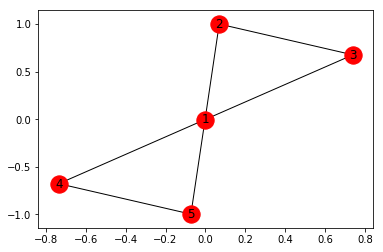

In [42]:
G11 = {1:{2,3,4,5}, 2:{1,3}, 3:{1,2}, 4: {1,5}, 5:{1,4}}
draw_graph(G11)

In [47]:
lp_entropy(G11)

{(2, 3, 4, 5): (1, 2, 3, 4, 5), (1, 3): (1, 2, 3), (1, 2): (1, 2, 3), (1, 5): (1, 4, 5), (1, 4): (1, 4, 5)}
mq (1,) (1, 2) (1, 2) (1,) 0 2 [ 1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
mq (1,) (1, 3) (1, 3) (1,) 0 2 [ 1.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
mq (1,) (1, 4) (1, 4) (1,) 0 14 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
mq (1,) (1, 5) (1, 5) (1,) 0 14 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
lq (1,) (2,) (1, 2) () 0 16 [-1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
lq (1,) (2, 3) (1, 2, 3) () 0 17 [-1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -

skipped lq (1, 3) (2, 3) (1, 2, 3) (3,) 2 17
lq (1, 3) (2, 3, 4) (1, 2, 3, 4) (3,) 2 18 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 -1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
skipped lq (1, 3) (2, 3, 4, 5) (1, 2, 3, 4, 5) (3,) 2 4
lq (1, 3) (2, 3, 5) (1, 2, 3, 5) (3,) 2 20 [ 0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
lq (1, 3) (2, 4) (1, 2, 3, 4) () 2 21 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
lq (1, 3) (2, 4, 5) (1, 2, 3, 4, 5) () 2 22 [ 0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
lq (1, 3) (2, 5) (1, 2, 3, 5) () 2 23 [ 0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
mq (1, 3) (3,) (1, 3) (3,) 2 24 [ 0.  0. -1.  0.  0.  0.  

  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  1. -1.  0.]
lq (2, 4) (5,) (2, 4, 5) () 21 30 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0. -1.]
mq (2, 4, 5) (2, 5) (2, 4, 5) (2, 5) 22 23 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.]
lq (2, 4, 5) (3,) (2, 3, 4, 5) () 22 24 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -1.  0. -1.  0.  0.  0.  0.  0.  0.]
lq (2, 4, 5) (3, 4) (2, 3, 4, 5) (4,) 22 25 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  1.  0.  0.]
lq (2, 4, 5) (3, 4, 5) (2, 3, 4, 5) (4, 5) 22 26 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. -1.  0.  0.  0. -1.  0.  0.  1.  0.]
lq (2, 4, 5) (3, 5) (2, 3, 4, 5) (5,) 22 27 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

     con: array([0., 0., 0., 0., 0.])
     fun: -3.0
 message: 'Optimization terminated successfully.'
     nit: 416
   slack: array([0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 2., 2., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0

In [ ]:
import scipy
scipy.optimize.show_options('linprog')

In [ ]:
x = np.array([1., 2., 2., 3., 3., 3., 3., 3., 3., 2., 3., 3., 3., 2., 2., 2., 1.,
       2., 3., 3., 3., 2., 2., 2., 1., 2., 2., 2., 1., 1., 1.])

In [ ]:
x.shape[0]

# Interesting results

In [ ]:
def check_approx_identical_entropy(G1, G2):
    entropy_g1 = lp_entropy(G1)
    entropy_g2 = lp_entropy(G2)
    print(np.round(entropy_g1.x))
    print(np.round(entropy_g2.x))
    return np.array_equal(np.round(entropy_g1.x), np.round(entropy_g2.x))

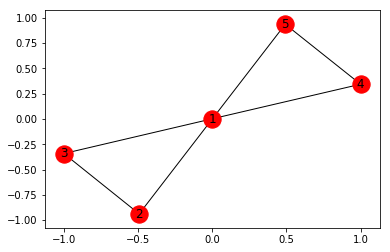

In [48]:
G1 = {1:{2,3,4,5}, 2:{1,3}, 3:{1,2}, 4: {1,5}, 5:{1,4}}
draw_graph(G1)

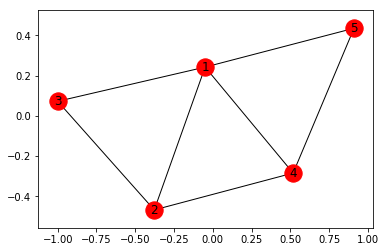

In [49]:
G2 = {1:{2,3,4,5}, 2:{1,3,4}, 3:{1,2}, 4: {1,2,5}, 5:{1,4}}
draw_graph(G2)

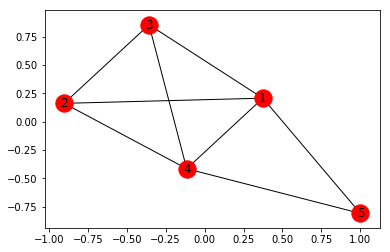

In [50]:
G3 = {1:{2,3,4,5}, 2:{1,3,4}, 3:{1,2,4}, 4: {1,2,3,5}, 5:{1,4}}
draw_graph(G3)

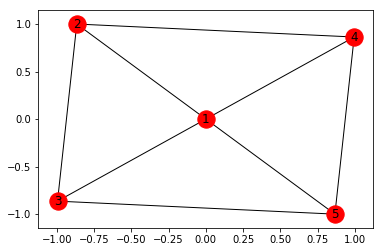

In [51]:
G4 = {1:{2,3,4,5}, 2:{1,3,4}, 3:{1,2,5}, 4: {1,2,5}, 5:{1,3,4}}
draw_graph(G4)

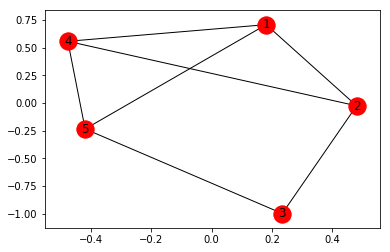

In [52]:
G5 = {1:{2,4,5}, 2:{1,3,4}, 3:{2,5}, 4: {1,2,5}, 5:{1,3,4}}
draw_graph(G5)

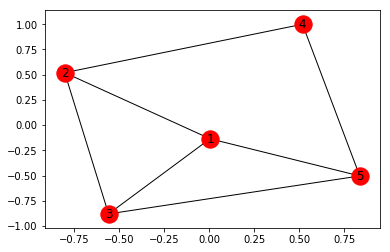

In [53]:
G6 = {1:{2,3,5}, 2:{1,3,4}, 3:{1,2,5}, 4: {2,5}, 5:{1,3,4}}
draw_graph(G6)

In [58]:
lp_entropy(G5)

{(2, 4, 5): (1, 2, 4, 5), (1, 3, 4): (1, 2, 3, 4), (2, 5): (2, 3, 5), (1, 2, 5): (1, 2, 4, 5), (1, 3, 4, 5): (1, 2, 3, 4)}
mq (1,) (1, 2) (1, 2) (1,) 0 1 [ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
mq (1,) (1, 3) (1, 3) (1,) 0 9 [ 1.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
mq (1,) (1, 4) (1, 4) (1,) 0 13 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
mq (1,) (1, 5) (1, 5) (1,) 0 15 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
lq (1,) (2,) (1, 2) () 0 16 [-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
lq (1,) (2, 3) (1, 2, 3) () 0 17 [-1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

lq (1, 3) (3, 4) (1, 3, 4) (3,) 9 25 [ 0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.]
lq (1, 3) (3, 4, 5) (1, 3, 4, 5) (3,) 9 26 [ 0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0. -1.  0.  0.  0.  0.]
lq (1, 3) (3, 5) (1, 3, 5) (3,) 9 27 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0.  0.]
lq (1, 3) (4,) (1, 3, 4) () 9 28 [ 0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.]
lq (1, 3) (4, 5) (1, 3, 4, 5) () 9 29 [ 0.  0.  0.  1.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
lq (1, 3) (5,) (1, 3, 5) () 9 30 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
skipped mq same p

mq (3,) (3, 4) (3, 4) (3,) 24 25 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.  0.]
mq (3,) (3, 5) (3, 5) (3,) 24 27 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.  0.  0.  0.]
lq (3,) (4,) (3, 4) () 24 28 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -1.  1.  0.  0. -1.  0.  0.]
lq (3,) (4, 5) (3, 4, 5) () 24 29 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  0. -1.  0.]
lq (3,) (5,) (3, 5) () 24 30 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0. -1.]
mq (3, 4) (3, 4, 5) (3, 4, 5) (3, 4) 25 26 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1. -1.  0.  0.  0.  0.]
lq (3, 4) (3, 5) (3, 4, 5) (3,) 25 27

     con: array([0., 0., 0., 0., 0.])
     fun: -2.9999999999999947
 message: 'Optimization terminated successfully.'
     nit: 486
   slack: array([ 3.99680289e-15,  3.99680289e-15,  1.11022302e-15,  4.88498131e-15,
        1.77635684e-15,  4.44089210e-16,  1.00000000e+00,  8.88178420e-16,
        1.00000000e+00,  1.00000000e+00,  0.00000000e+00,  5.32907052e-15,
       -4.44089210e-16,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        4.88498131e-15,  4.44089210e-16,  1.00000000e+00,  1.00000000e+00,
        6.43929354e-15,  1.11022302e-15,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  2.66453526e-15, -4.44089210e-16,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        3.99680289e-15,  1.33226763e-15,  1.00000000e+00,  1.33226763e-15,
        2.00000000e+00,  2.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.000000